# LC3 DATA ANALYSIS

### Load libraries and data

In [1]:
# Libraries for general data management
import pandas as pd
import numpy  as np

In [2]:
# Libraries for creating and validating models
from sklearn.linear_model    import LinearRegression
from sklearn.metrics         import mean_squared_error
from sklearn.model_selection import LeaveOneOut, cross_val_predict, cross_val_score

In [3]:
# Libraries for data visualization
import matplotlib.pyplot  as plt
import matplotlib.patches as mpatches

In [4]:
# Input file path (can be also an excel)
DATA_PATH = './data/data_merged.ods'

In [5]:
# https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_excel.html

# Read data skipping the first row and considering also '-' as NaN
data = pd.read_excel(DATA_PATH, skiprows=[0], na_values=['-'])

In [6]:
# We rename some columns for having an easier reference
data.rename(columns = {'Calcined kaolinite content (%)':'Kaolinite_content'}, inplace = True)
data.rename(columns = {'Dv,50 (µm)':'Dv50'                                 }, inplace = True)
data.rename(columns = {'BET Specific surface (m2/g)':'BET_specific_surface'}, inplace = True)

data.rename(columns = {'STD'  : 'STD_1D'}, inplace = True)
data.rename(columns = {'STD.1': 'STD_3D'}, inplace = True)
data.rename(columns = {'STD.2': 'STD_7D'}, inplace = True)
data.rename(columns = {'STD.3':'STD_28D'}, inplace = True)
data.rename(columns = {'STD.4':'STD_90D'}, inplace = True)

# Sorting allows us to plot functions more easily
data = data.sort_values('Kaolinite_content')

# Get useful dataframe information
#data               # Get data
#data.describe()    # Get data general information
#data.columns       # Get data features names
#data.corr()        # Get correlation matrix

### Visualize data

In [7]:
# Take kaolinite content
x = data['Kaolinite_content'].values # (Pandas dataframe).values = numpy array

# Take compression strengths
y1  = data[ "1D"].values
y3  = data[ "3D"].values
y7  = data[ "7D"].values
y28 = data["28D"].values
y90 = data["90D"].values

# Measures at 90 days have missing values (4 in total)
x90 =   x[np.logical_not(np.isnan(y90))]
y90 = y90[np.logical_not(np.isnan(y90))]

# Take standard deviations
#z1  = data[ "STD_1D"].values
#z3  = data[ "STD_3D"].values
#z7  = data[ "STD_7D"].values
#z28 = data["STD_28D"].values
#z90 = data["STD_90D"].values

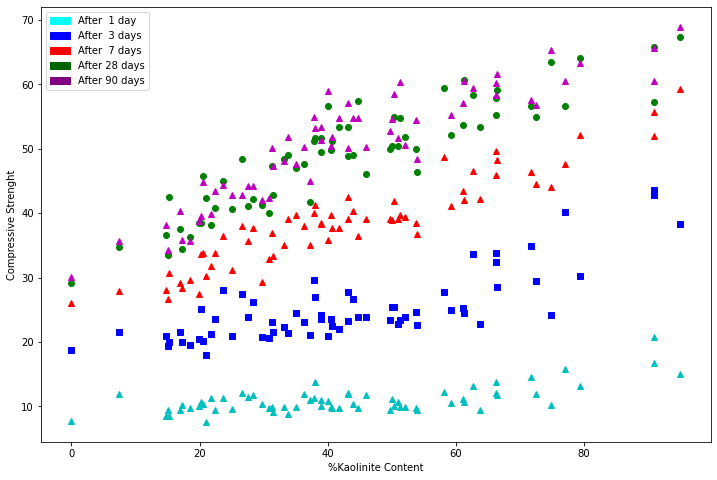

In [19]:
# Show points using matplotlib.pyplot library
fig, ax = plt.subplots(figsize=(12, 8))
plt.plot(x,y1,'c^',x,y3,'bs',x,y7,'r^',x,y28,'go', x90,y90,'m^')
plt.xlabel('%Kaolinite Content')
plt.ylabel('Compressive Strenght')

d1_patch  = mpatches.Patch(color='cyan',      label='After  1 day')
d3_patch  = mpatches.Patch(color='blue',      label='After  3 days')
d7_patch  = mpatches.Patch(color='red',       label='After  7 days')
d28_patch = mpatches.Patch(color='darkgreen', label='After 28 days')
d90_patch = mpatches.Patch(color='purple',    label='After 90 days')
plt.legend(handles=[d1_patch,d3_patch,d7_patch,d28_patch,d90_patch])

plt.show()

**First sight analysis:**

* **CS Day 1:** Almost constant, it curves from kaolinite content 50%, try degree two feature expansion.
* **CS Day 3:** Sparse points, we need to add another feature and maybe try also feature expansion.
* **CS Day 7:** The straight line is quite clear, we can try adding another feature for avoiding sparsification.
* **CS Day 28:** Straight line until 40% kaolinite content, then it curves. Feature expansion is needed as well as another feature for reducing sparsification.
* **CS Day 90:** Totally analogous than the day 28 data.


**Second sight analysis:**
* Maybe it would be interesting to have a predictor of the compression strength at 90 days (at time=infinity) knowing the compression strength before.
* In feature augmentation never go further than degree two, the curve is clearly always increasing.
* When having models involving only one or two features it's going to be important to plot for checking correctness.
* We have to search also mathematical measurements for the correctness of our models.

### Data correlation analysis

We have measures of 21 features/properties of the clays. Which are the (cor)relations among them? Which are the most important for predicting the compression strength? Are there redundancies? 

The first analysis for answering that question is going to be given by analyzing the correlations.

In [20]:
# Function to hightlight high correlated cells in red
def highlight_high_correlations(cell):
    return 'background-color: %s' % ('red' if (cell != 1 and abs(cell) > CORRELATION_THRESHOLD) else 'white')

In [21]:
# Correlation between clays properties themselves
CORRELATION_THRESHOLD = 0.6

corr_matrix = data.corr()[10:].iloc[:, 10:]
corr_matrix.style.applymap(highlight_high_correlations)

,Kaolinite_content,Dv50,D10,D90,Span (-),BET_specific_surface,SiO2,Al2O3,Fe2O3,CaO,MgO,SO3,Na2O,K2O,TiO2,P2O5,MnO,Others,LOI
Kaolinite_content,1.000000,-0.193017,-0.305015,-0.244189,0.084664,0.089423,-0.660779,0.916209,-0.254266,-0.202572,-0.338773,0.016628,-0.200614,-0.411239,0.414770,-0.035480,0.316228,0.024821,0.231897
Dv50,-0.193017,1.000000,0.451829,0.776255,0.119163,-0.015583,0.287292,-0.242921,-0.189271,0.042118,0.052258,0.077456,-0.096222,0.074709,-0.006009,0.385650,0.255514,-0.084343,-0.230361
D10,-0.305015,0.451829,1.000000,-0.035547,-0.436280,-0.404479,0.382222,-0.145179,-0.431953,-0.214363,-0.187739,0.225985,0.012912,0.618675,-0.589368,0.378885,-0.771972,-0.200548,-0.064193
D90,-0.244189,0.776255,-0.035547,1.000000,0.736569,-0.089815,0.193764,-0.340139,-0.028480,0.342000,0.365395,0.975371,-0.132507,0.047146,-0.043585,0.138796,-0.142464,-0.011756,-0.171109
Span (-),0.084664,0.119163,-0.436280,0.736569,1.000000,0.101806,-0.072553,-0.042011,0.082441,0.072997,-0.075898,0.033117,-0.094787,-0.161342,0.197525,-0.029135,0.115944,-0.168370,-0.043502
BET_specific_surface,0.089423,-0.015583,-0.404479,-0.089815,0.101806,1.000000,-0.421059,0.052440,0.619421,-0.100527,0.147891,-0.151082,-0.016290,-0.183056,0.099011,-0.142684,0.643980,-0.342051,0.152745
SiO2,-0.660779,0.287292,0.382222,0.193764,-0.072553,-0.421059,1.000000,-0.725183,-0.364198,-0.108063,-0.181542,-0.208559,-0.144506,0.130411,-0.410854,-0.038594,-0.305488,0.057821,-0.390461
Al2O3,0.916209,-0.242921,-0.145179,-0.340139,-0.042011,0.052440,-0.725183,1.000000,-0.282481,-0.211962,-0.286575,-0.169586,-0.213801,-0.315134,0.369314,-0.051612,0.372933,-0.036482,0.308423
Fe2O3,-0.254266,-0.189271,-0.431953,-0.028480,0.082441,0.619421,-0.364198,-0.282481,1.000000,0.004174,0.231275,0.008352,0.158245,-0.114540,0.208177,0.095215,0.104339,-0.108749,-0.060084
CaO,-0.202572,0.042118,-0.214363,0.342000,0.072997,-0.100527,-0.108063,-0.211962,0.004174,1.000000,0.569413,0.625109,0.496111,-0.086462,-0.304487,-0.135553,-0.081563,0.128110,0.067826


In [22]:
# Correlation between Compression Strength measurements and clays properties
CORRELATION_THRESHOLD = 0.5

corr_matrix = data.corr()[10:].iloc[:, [0,2,4,6,8]]
corr_matrix.style.applymap(highlight_high_correlations)

,1D,3D,7D,28D,90D
Kaolinite_content,0.658071,0.781898,0.930966,0.900876,0.911653
Dv50,-0.111246,-0.011320,-0.116061,-0.146193,-0.152193
D10,-0.274278,-0.351558,-0.296297,-0.287737,-0.290692
D90,-0.225330,-0.169381,-0.147715,-0.131897,-0.141472
Span (-),-0.008618,0.096408,0.176071,0.178734,0.099044
BET_specific_surface,-0.077832,-0.032558,0.083831,0.108786,0.198791
SiO2,-0.430950,-0.443933,-0.563664,-0.579837,-0.635442
Al2O3,0.614406,0.705345,0.834569,0.809226,0.845753
Fe2O3,-0.268702,-0.284461,-0.265054,-0.259344,-0.242389
CaO,-0.171936,-0.143753,-0.217687,-0.181013,-0.136114


In [23]:
# Correlation between standard deviations of measurements and clays properties
CORRELATION_THRESHOLD = 0.2

corr_matrix = data.corr()[10:].iloc[:, [1,3,5,7,9]]
corr_matrix.style.applymap(highlight_high_correlations)

,STD_1D,STD_3D,STD_7D,STD_28D,STD_90D
Kaolinite_content,0.098020,0.462649,0.183329,0.358627,0.191225
Dv50,-0.118125,-0.129720,-0.113932,-0.185816,-0.105022
D10,-0.159055,-0.401368,-0.215840,-0.224444,-0.245231
D90,-0.018398,-0.070994,-0.032689,-0.082954,0.184129
Span (-),0.020704,0.055594,0.044010,0.022846,0.143911
BET_specific_surface,-0.345532,0.010624,-0.092784,0.131376,-0.059141
SiO2,0.006149,-0.302855,-0.086754,-0.322744,-0.080277
Al2O3,0.029920,0.394946,0.248389,0.322680,0.106657
Fe2O3,-0.137893,-0.100728,-0.108874,0.004947,0.019647
CaO,0.140246,0.012872,-0.146547,-0.101726,0.134408


**First sight analysis:**

* Several important correlations between features, be aware of this when chosing features for our model to avoid redundancy.
* Compression strength can be predicted quite good with only the Kaolinite content, the relation is clear.
* At first sight there is no clear evidence of any feature being behind the standard deviation/variability of lc3.

# COMPRESSION STRENGTH (CS)

### Feature selection

We have seen the importance and the clear relation of the Kaolinite conent with the compression strength and, we have seen also that the models involving only kaolinite content have their limitations (because of data sparsification). For achieving better results we have to add more modelation expressiveness by adding other variables to our model (new features or other artificially created) and, since the data distribution makes us think that linear regression models with the kaolinite content in degree three or more lead to overfitting, the best choice is adding new features.

Again, for avoiding overfitting with the few data we have we can't add several features so we have to decide well which is the best feature for complementing the kaolinite content. That's is the question we try to solve in this part.

In [24]:
# Which features are realiable? Those with more than RELIABLE_THRESHOLD measurements
RELIABLE_THRESHOLD = 45

features = data.columns[14:]
reliable_features = [f for f in features if data[f].describe()[0] >= RELIABLE_THRESHOLD]

In [25]:
# Show the reliable features, with enough points to rely
reliable_features

['Dv50',
 'Span (-)',
 'BET_specific_surface',
 'SiO2',
 'Al2O3',
 'Fe2O3',
 'CaO',
 'MgO',
 'Na2O',
 'K2O',
 'TiO2',
 'P2O5',
 'LOI']

In [26]:
# Function to return the R2 and validation score for a model (linear regression by default)
def model_validation(X, y, model=LinearRegression()):
    # Train the model
    model.fit(X, y) 
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Return the metrics
    return model.score(X,y), mean_squared_error(y, predicted)

In [27]:
# TODO: We are computing metrics for every feature, why not building a matrix with all te information?

# Function to perform feature selection from those given as parameter. It choses those
# features that better complements kaolinite content for achieving the best R2 and MSE.
def feature_selection(features, days=[1,3,7,28,90]):
    # For every day we want to do feature selection
    for i in days:    
        day = str(i) + 'D'
        bestR2  = -1 
        bestMse = float('inf')
        
        # Go for every feature given and check wich results we get with it
        for feature in features:
            # IMPORTANT! Metrics can cheat us if we drop NaNs!!
            # IMPORTANT! That's what we have to rely the features we are testing!!
            df = data[['Kaolinite_content', feature, day]].dropna()
            df['Kaolinite_content_square'] = (df['Kaolinite_content'].values)**2
            
            # Kaolinite content is always in our features in degree one and two
            X = df[['Kaolinite_content', 'Kaolinite_content_square', feature]].values
            y = df[day].values
        
            # Get the metrics
            r2, mse = model_validation(X,y)
            
            # Keep the bests
            if r2 > bestR2:
                bestR2         = r2
                bestR2_mse     = mse
                bestR2_feature = feature
            
            if mse < bestMse:
                bestMse        = mse
                bestMse_r2     = r2
                bestMse_feature= feature
        
            #print('Kaolinite content +  Kaolinite content square + '+feature)
            #print('R2:  '+str(r2))
            #print('MSE: '+str(mse))
        
        # Print report for this day 
        print('=============================================================================')
        print('Best features for compression strength at day '+str(i))
        print('=============================================================================')
        print()
        print('Best R2  achieved for degree two kaolinite content and '+bestR2_feature)
        print('R2:  '+str(bestR2))
        print('MSE: '+str(bestR2_mse))
        print()
        print('Best MSE achieved for degree two kaolinite content and '+bestMse_feature)
        print('R2:  '+str(bestMse_r2))
        print('MSE: '+str(bestMse))
        print()

In [28]:
feature_selection(reliable_features)

Best features for compression strength at day 1

Best R2  achieved for degree two kaolinite content and Dv50
R2:  0.6315925295954326
MSE: 2.6603871793001117

Best MSE achieved for degree two kaolinite content and CaO
R2:  0.22656925034053543
MSE: 1.7513794750701202

Best features for compression strength at day 3

Best R2  achieved for degree two kaolinite content and Dv50
R2:  0.7714004286007227
MSE: 10.144908976626628

Best MSE achieved for degree two kaolinite content and CaO
R2:  0.3961623395626972
MSE: 8.579012335663231

Best features for compression strength at day 7

Best R2  achieved for degree two kaolinite content and BET_specific_surface
R2:  0.902082709239957
MSE: 6.499024023048374

Best MSE achieved for degree two kaolinite content and Span (-)
R2:  0.9010330459247408
MSE: 6.230590276426987

Best features for compression strength at day 28

Best R2  achieved for degree two kaolinite content and BET_specific_surface
R2:  0.845924125053688
MSE: 14.141629659648183

Best MSE a

In [29]:
feature_selection(features)

Best features for compression strength at day 1

Best R2  achieved for degree two kaolinite content and D10
R2:  0.7436635898992177
MSE: 3.232964850213088

Best MSE achieved for degree two kaolinite content and MnO
R2:  0.42377078680904934
MSE: 1.4895541484342507

Best features for compression strength at day 3

Best R2  achieved for degree two kaolinite content and D10
R2:  0.8469189621219806
MSE: 10.059604164151873

Best MSE achieved for degree two kaolinite content and MnO
R2:  0.4658706320728524
MSE: 7.000614752834034

Best features for compression strength at day 7

Best R2  achieved for degree two kaolinite content and D90
R2:  0.9351933348995638
MSE: 6.328872056304233

Best MSE achieved for degree two kaolinite content and Span (-)
R2:  0.9010330459247408
MSE: 6.230590276426987

Best features for compression strength at day 28

Best R2  achieved for degree two kaolinite content and D90
R2:  0.9185168138071385
MSE: 11.090342053034817

Best MSE achieved for degree two kaolinite co

### Linear regression models

We have seen that the kaolinite content is the most predictive feature that we have. We are going to start creating simple linear regression models and then, following the appreciations obtained by visualizing the data, we are going to create non-linear models based on the kaolinite content for better fitting the data distribution as well as models with more features for avoiding data sparsification.

Two metrics are going to be extremely important here:
* **R square:** Is giving us a measurement of how good is our model (the closer to 1.0 the better). 
* **Validation score:** Is going to let us control overfitting. Improving R² means nothing if validation is worse. We'll use mean squared error with Leave One Out cross validation to estimate it.

In [30]:
# TODO: Remove outlier in y1 data?
# TODO: Idea for the report, removing pesimist outliers is not a good idea in our project!
# TODO: Add OPC compression strength values for reference

#### Linear models based on the kaolinite content

In [31]:
# Create, estimate, validate and show the model
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train the model
    model.fit(X, y) 
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X, np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X, y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Model and metrics
    print('f(x) = {0} + {1}*x'.format(model.intercept_, model.coef_[0]))
    print()
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

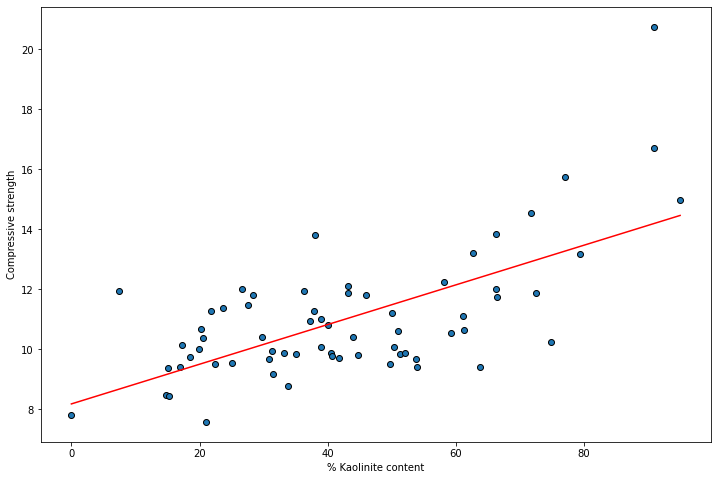

f(x) = 8.182078798084477 + 0.06610392732898104*x

MSE: 2.831728556226933
R^2: 0.4330574737902103


In [32]:
leave_one_out_validation(x.reshape(-1,1), y1)

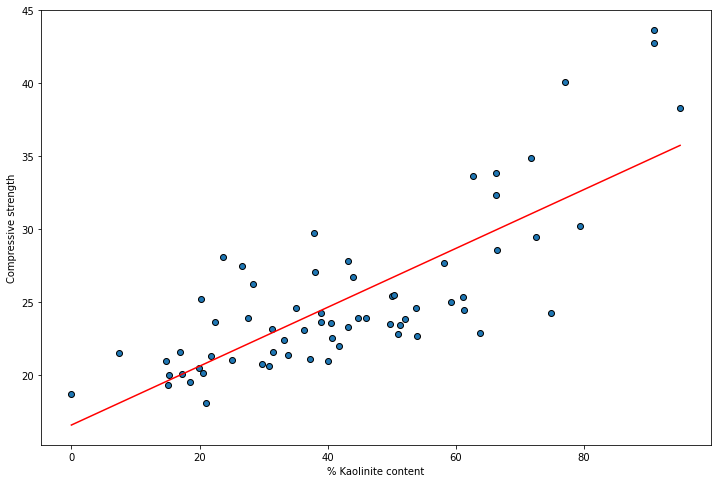

f(x) = 16.544774345389964 + 0.20197895450867684*x

MSE: 12.675898171489052
R^2: 0.6113650603318864


In [33]:
leave_one_out_validation(x.reshape(-1,1), y3)

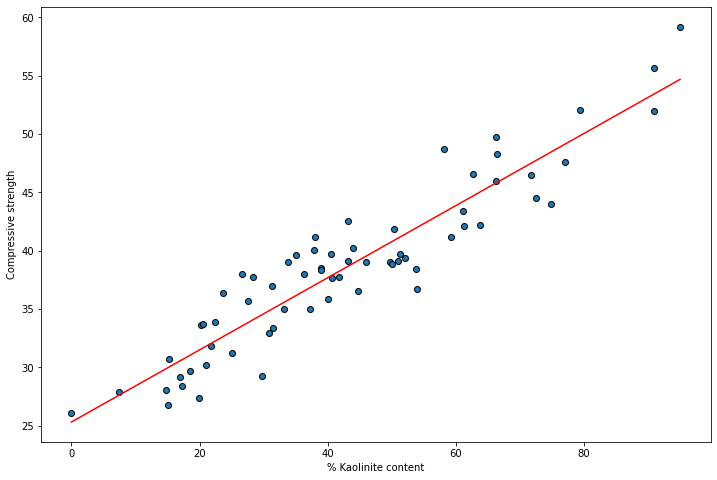

f(x) = 25.30760246706364 + 0.30925338626977783*x

MSE: 7.00392455294012
R^2: 0.8666969837714468


In [34]:
leave_one_out_validation(x.reshape(-1,1), y7)

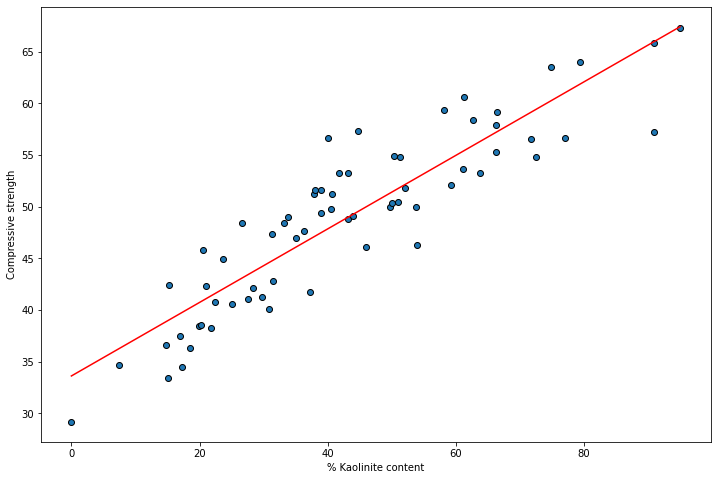

f(x) = 33.62781210162508 + 0.3558471318971575*x

MSE: 14.031208977513867
R^2: 0.8115769970840359


In [35]:
leave_one_out_validation(x.reshape(-1,1), y28)

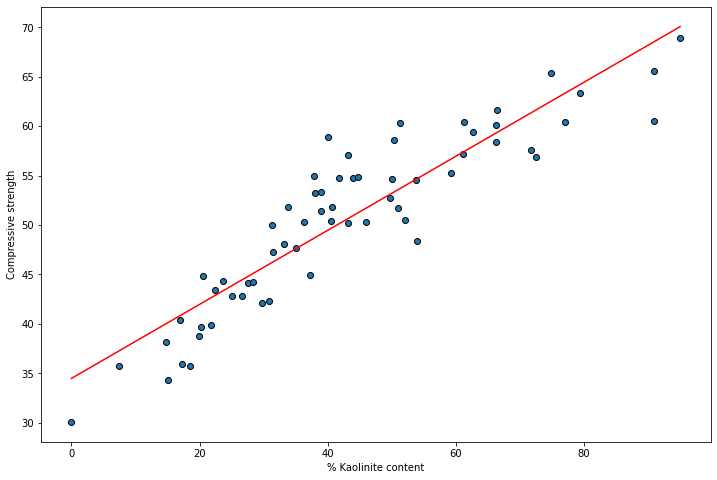

f(x) = 34.473502265715304 + 0.3745752546931824*x

MSE: 13.593520931397066
R^2: 0.8311103650575946


In [36]:
leave_one_out_validation(x90.reshape(-1,1), y90)

**First sight analysis:**

* There is few more we can improve at the 7th day using only the kaolinite content, data distribution is quite a straight line.
* For 1st and 3rd day the problem is more the sparsification of the points than the lack of expresivity of the model.
* For 28th and 90th day until 40% of kaolinite content the compression strength increases linearly and then estabilizes. Makes sense a non-linear model.
* It doesn't make sense in any model a degree 3 regression model, compression strength increases with kaolinite content.

#### Non-linear models based on the kaolinite content

In [31]:
# x_2 = Kaolinite content, (Kaolinite content)^2
x_2   = np.array([x, x**2]).T
x90_2 = np.array([x90,x90*x90]).T 

In [32]:
# Same function than before but adapted for degree two case
def leave_one_out_validation(X, y, model=LinearRegression()):
    # Train and show the model
    model.fit(X, y) 
    
    # This could be generalized but degree n >= 3 leads to overfitting!
    print('f(x) = {0} + {1}*x + {2}*x^2'.format(model.intercept_, model.coef_[0], model.coef_[1]))
        
    # Get the list of predictions obtained while validating
    predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())
    
    # Plot the results
    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
    ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))
    ax.set_xlabel('% Kaolinite content')
    ax.set_ylabel('Compressive strength')
    plt.show()
    
    # Metrics for the model
    print("MSE: {}".format(mean_squared_error(y, predicted)))
    print("R^2: {}".format(model.score(X,y)))

f(x) = 10.478219444077304 + -0.05802811082833178*x + 0.0013110628728686142*x^2


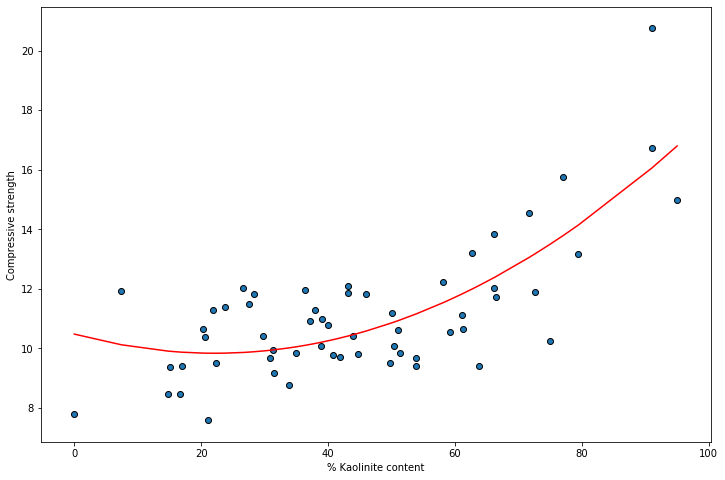

MSE: 2.6221974455456207
R^2: 0.564069137329487


In [33]:
leave_one_out_validation(x_2, y1)

f(x) = 22.316531996062583 + -0.09575207161375508*x + 0.003085951064221629*x^2


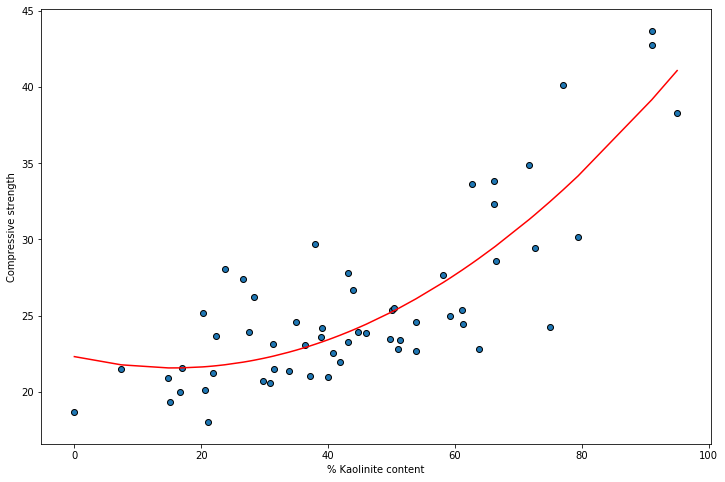

MSE: 11.202749432292585
R^2: 0.69135745568661


In [34]:
leave_one_out_validation(x_2, y3)

f(x) = 26.66552702242966 + 0.25206303943102093*x + 0.0005251268763280832*x^2


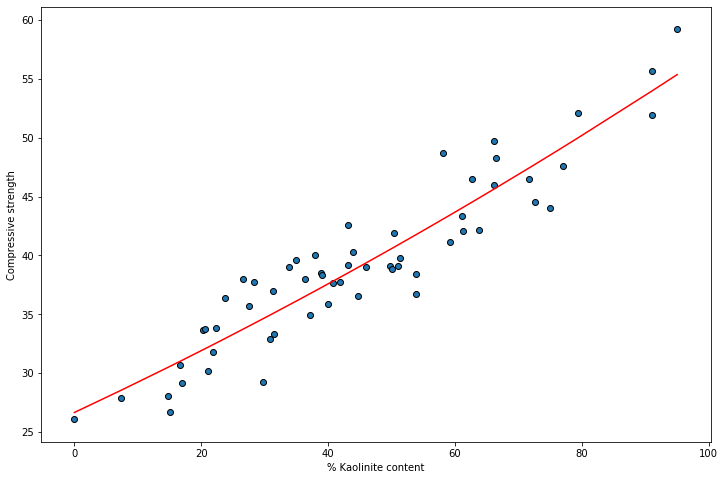

MSE: 7.213031472294101
R^2: 0.8685367928317549


In [35]:
leave_one_out_validation(x_2, y7)

f(x) = 30.1573044441616 + 0.5524183450320862*x + -0.0021314323080568326*x^2


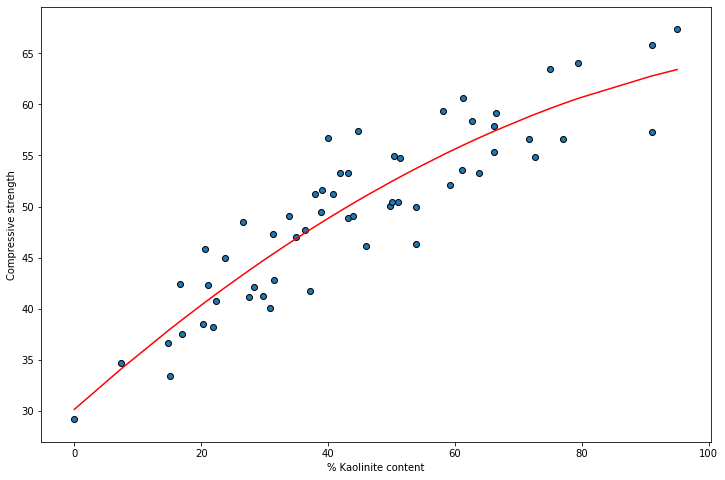

MSE: 13.38951338501839
R^2: 0.8273317550793433


In [36]:
leave_one_out_validation(x_2, y28)

f(x) = 29.394944062897192 + 0.6625193043103382*x + -0.0030766912379724103*x^2


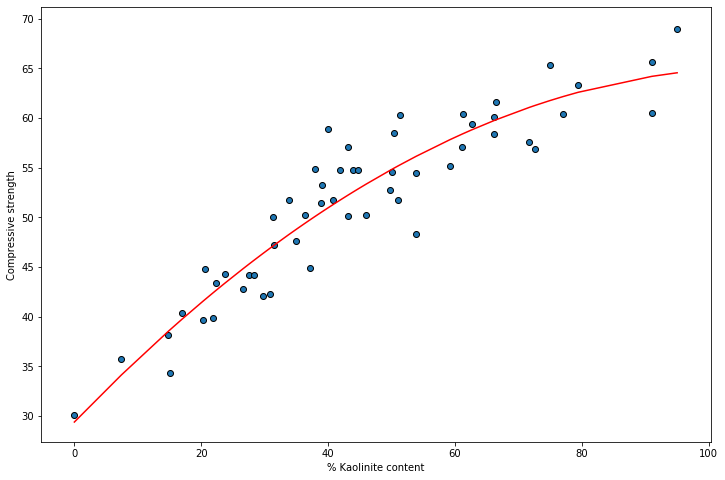

MSE: 10.545891820955662
R^2: 0.8717081451424198


In [37]:
leave_one_out_validation(x90_2, y90)

**First sight analysis:**

* Expected results, better models obtained for 28th and 90th day compression strength obtained.
* We might be experiencing overfitting with this model for 1st and 3rd day measurements because we're not increasing the compressive strength with the increase of calonita for small contents.

#### Linear regression models based on the kaolinite content and other features

Following the results obtained in the feature selection part, here we are creating and analyzing the models done with the kaolinite conent (in degree one and two) as well as other feature.

In [38]:
# TODO: The most important question here is to be (dropped the NaN) or not to be (and then replace them)

In [39]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [40]:
# Funcion for returning the data ready for creating models with kaolinite and a given feature
def get_model_data(feature, day, drop_nan=True, replace_nan=False):
    # Get kaolinite content in degree one and two and the parameter feature
    df_aux = data[['Kaolinite_content', feature, day]]
    df_aux.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
    # Copy for data integrity if we replace NaN
    df_aux = df_aux.copy()
    
    if drop_nan:
        df_aux = df_aux.dropna()
    elif replace_nan:
        df_aux.fillna(value=df_aux[feature].mean(), inplace=True)
    
    df_aux.rename(columns = {day : 'day_'+day[0]}, inplace = True)
    
    return df_aux

In [41]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data('Dv50','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.632
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     25.71
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           7.68e-10
Time:                        12:49:41   Log-Likelihood:                -86.899
No. Observations:                  49   AIC:                             181.8
Df Residuals:                      45   BIC:                             189.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    9.7052      0.960     10.105      0.000       7.771      11.640
Kaolinite_content           -0.0310      0.038     -0.806      0.425      -0.109       0.047
Kaolinite_content_square     0.0011      0.000      2.971      0.005       0.000       0.002
Dv50                         0.0086      0.030      0.285      0.777      -0.052       0.069
==============================================================================
Omnibus:                        3.012   Durbin-Watson:                   1.954
Prob(Omnibus):                  0.222   Jarque-Bera (JB):                2.083
Skew:                           0.472   Prob(JB):                        0.353
Kurtosis:                       3.357   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [42]:
# Day 1 
mod = smf.ols(formula='day_1 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data('CaO','1D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_1   R-squared:                       0.227
Model:                            OLS   Adj. R-squared:                  0.174
Method:                 Least Squares   F-statistic:                     4.297
Date:                Fri, 27 Nov 2020   Prob (F-statistic):            0.00961
Time:                        12:49:48   Log-Likelihood:                -75.651
No. Observations:                  48   AIC:                             159.3
Df Residuals:                      44   BIC:                             166.8
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   10.3191      0.931     11.082      0.000       8.442      12.196
Kaolinite_content           -0.0208      0.046     -0.453      0.653      -0.113       0.072
Kaolinite_content_square     0.0006      0.001      1.176      0.246      -0.000       0.002
CaO                         -0.0601      0.102     -0.589      0.559      -0.266       0.146
==============================================================================
Omnibus:                        1.110   Durbin-Watson:                   2.045
Prob(Omnibus):                  0.574   Jarque-Bera (JB):                0.966
Skew:                           0.112   Prob(JB):                        0.617
Kurtosis:                       2.342   Cond. No.                     1.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [43]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + Dv50', data=get_model_data('Dv50','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     50.61
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.83e-14
Time:                        12:49:48   Log-Likelihood:                -121.25
No. Observations:                  49   AIC:                             250.5
Df Residuals:                      45   BIC:                             258.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   20.6470      1.936     10.664      0.000      16.747      24.547
Kaolinite_content           -0.0943      0.078     -1.216      0.230      -0.251       0.062
Kaolinite_content_square     0.0033      0.001      4.280      0.000       0.002       0.005
Dv50                         0.1179      0.060      1.950      0.057      -0.004       0.240
==============================================================================
Omnibus:                        2.096   Durbin-Watson:                   1.993
Prob(Omnibus):                  0.351   Jarque-Bera (JB):                1.859
Skew:                           0.363   Prob(JB):                        0.395
Kurtosis:                       2.380   Cond. No.                     1.52e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.52e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [44]:
# Day 3
mod = smf.ols(formula='day_3 ~ Kaolinite_content + Kaolinite_content_square + CaO', data=get_model_data('CaO','3D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_3   R-squared:                       0.396
Model:                            OLS   Adj. R-squared:                  0.354
Method:                 Least Squares   F-statistic:                     9.603
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           5.38e-05
Time:                        12:49:48   Log-Likelihood:                -116.04
No. Observations:                  48   AIC:                             240.1
Df Residuals:                      44   BIC:                             247.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   21.0784      2.160      9.759      0.000      16.725      25.431
Kaolinite_content            0.0193      0.106      0.182      0.857      -0.195       0.233
Kaolinite_content_square     0.0012      0.001      0.978      0.333      -0.001       0.004
CaO                         -0.0299      0.237     -0.126      0.900      -0.507       0.447
==============================================================================
Omnibus:                        7.797   Durbin-Watson:                   1.921
Prob(Omnibus):                  0.020   Jarque-Bera (JB):                7.035
Skew:                           0.912   Prob(JB):                       0.0297
Kurtosis:                       3.441   Cond. No.                     1.35e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.35e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [45]:
# Day 7
mod = smf.ols(formula='day_7 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','7D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_7   R-squared:                       0.902
Model:                            OLS   Adj. R-squared:                  0.895
Method:                 Least Squares   F-statistic:                     135.0
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           3.26e-22
Time:                        12:49:48   Log-Likelihood:                -108.79
No. Observations:                  48   AIC:                             225.6
Df Residuals:                      44   BIC:                             233.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   26.1036      1.330     19.625      0.000      23.423      28.784
Kaolinite_content            0.2860      0.063      4.504      0.000       0.158       0.414
Kaolinite_content_square     0.0003      0.001      0.424      0.674      -0.001       0.002
BET_specific_surface         0.0019      0.026      0.073      0.942      -0.051       0.054
==============================================================================
Omnibus:                        6.253   Durbin-Watson:                   1.944
Prob(Omnibus):                  0.044   Jarque-Bera (JB):                2.697
Skew:                           0.273   Prob(JB):                        0.260
Kurtosis:                       1.975   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [46]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_2   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     81.75
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           5.06e-18
Time:                        12:49:48   Log-Likelihood:                -126.80
No. Observations:                  48   AIC:                             261.6
Df Residuals:                      44   BIC:                             269.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.5305      1.936     15.256      0.000      25.629      33.432
Kaolinite_content            0.6248      0.092      6.761      0.000       0.439       0.811
Kaolinite_content_square    -0.0029      0.001     -3.121      0.003      -0.005      -0.001
BET_specific_surface        -0.0219      0.038     -0.576      0.568      -0.098       0.055
==============================================================================
Omnibus:                        4.370   Durbin-Watson:                   2.229
Prob(Omnibus):                  0.112   Jarque-Bera (JB):                1.885
Skew:                          -0.048   Prob(JB):                        0.390
Kurtosis:                       2.034   Cond. No.                     1.26e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.26e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [47]:
# Day 28
mod = smf.ols(formula='day_2 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data('TiO2','28D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_2   R-squared:                       0.840
Model:                            OLS   Adj. R-squared:                  0.831
Method:                 Least Squares   F-statistic:                     89.38
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           2.62e-20
Time:                        12:49:49   Log-Likelihood:                -142.02
No. Observations:                  55   AIC:                             292.0
Df Residuals:                      51   BIC:                             300.1
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.1441      2.169     13.435      0.000      24.789      33.499
Kaolinite_content            0.5343      0.091      5.874      0.000       0.352       0.717
Kaolinite_content_square    -0.0021      0.001     -2.340      0.023      -0.004      -0.000
TiO2                         1.1688      0.651      1.796      0.078      -0.138       2.476
==============================================================================
Omnibus:                        4.739   Durbin-Watson:                   2.427
Prob(Omnibus):                  0.094   Jarque-Bera (JB):                2.042
Skew:                          -0.052   Prob(JB):                        0.360
Kurtosis:                       2.062   Cond. No.                     1.62e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.62e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [48]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + BET_specific_surface', data=get_model_data('BET_specific_surface','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_9   R-squared:                       0.894
Model:                            OLS   Adj. R-squared:                  0.886
Method:                 Least Squares   F-statistic:                     112.5
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.55e-19
Time:                        12:49:49   Log-Likelihood:                -109.43
No. Observations:                  44   AIC:                             226.9
Df Residuals:                      40   BIC:                             234.0
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.9502      1.746     16.585      0.000      25.422      32.478
Kaolinite_content            0.7102      0.085      8.392      0.000       0.539       0.881
Kaolinite_content_square    -0.0035      0.001     -4.311      0.000      -0.005      -0.002
BET_specific_surface        -0.0191      0.035     -0.552      0.584      -0.089       0.051
==============================================================================
Omnibus:                        0.608   Durbin-Watson:                   2.314
Prob(Omnibus):                  0.738   Jarque-Bera (JB):                0.720
Skew:                           0.162   Prob(JB):                        0.698
Kurtosis:                       2.463   Cond. No.                     1.29e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.29e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
# Day 90
mod = smf.ols(formula='day_9 ~ Kaolinite_content + Kaolinite_content_square + TiO2', data=get_model_data('TiO2','90D'))
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  day_9   R-squared:                       0.878
Model:                            OLS   Adj. R-squared:                  0.871
Method:                 Least Squares   F-statistic:                     113.2
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.63e-21
Time:                        12:49:49   Log-Likelihood:                -125.59
No. Observations:                  51   AIC:                             259.2
Df Residuals:                      47   BIC:                             266.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   28.0111      2.079     13.473      0.000      23.829      32.194
Kaolinite_content            0.6718      0.085      7.906      0.000       0.501       0.843
Kaolinite_content_square    -0.0032      0.001     -3.945      0.000      -0.005      -0.002
TiO2                         0.8563      0.590      1.452      0.153      -0.330       2.043
==============================================================================
Omnibus:                        0.114   Durbin-Watson:                   2.116
Prob(Omnibus):                  0.945   Jarque-Bera (JB):                0.305
Skew:                          -0.064   Prob(JB):                        0.858
Kurtosis:                       2.643   Cond. No.                     1.71e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.71e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Confidence analysis for the models

We know our model (function depending on the features provided) as well as some metrics to have an idea of how well our model fits our data (R2) and how is it behaving in practice with new data (MSE). The objetive of this section is to provide a more mathematical analysis of the confidence we can expect from our models.

#### Toy example for putting things into practice

We are going to start with the Kaolinite content based model for compression strength at day 90 to exemplify the tools and techniques we can use to estimate confidence intervals in our model.

In [60]:
data_90 = data[['Kaolinite_content', '90D']].copy()
data_90.insert(1, 'Kaolinite_content_square', data['Kaolinite_content']**2, True)
data_90 = data_90.dropna()

data_90.rename(columns = {'90D' : 'day_90'}, inplace = True)

In [61]:
# Day 90
mod = smf.ols(formula='day_90 ~ Kaolinite_content + Kaolinite_content_square', data=data_90)
np.random.seed(2)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 day_90   R-squared:                       0.872
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     173.3
Date:                Fri, 27 Nov 2020   Prob (F-statistic):           1.82e-23
Time:                        13:07:20   Log-Likelihood:                -137.09
No. Observations:                  54   AIC:                             280.2
Df Residuals:                      51   BIC:                             286.1
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
============================================================================================
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   29.3949      1.741     16.881      0.000      25.899      32.891
Kaolinite_content            0.6625      0.076      8.727      0.000       0.510       0.815
Kaolinite_content_square    -0.0031      0.001     -4.104      0.000      -0.005      -0.002
==============================================================================
Omnibus:                        0.027   Durbin-Watson:                   2.042
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.061
Skew:                           0.030   Prob(JB):                        0.970
Kurtosis:                       2.846   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

f(x) = 29.394944062897192 + 0.6625193043103382*x + -0.0030766912379724103*x^2


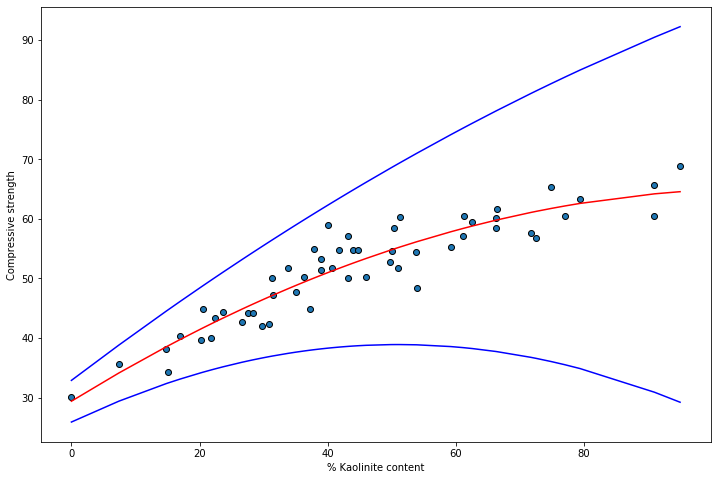

MSE: 10.545891820955662
R^2: 0.8717081451424198


In [66]:
X = data_90[['Kaolinite_content','Kaolinite_content_square']].values
y = data_90['day_90']

# Train and show the model
model = LinearRegression()
model.fit(X, y) 

# This could be generalized but degree n >= 3 leads to overfitting!
print('f(x) = {0} + {1}*x + {2}*x^2'.format(model.intercept_, model.coef_[0], model.coef_[1]))
    
# Get the list of predictions obtained while validating
predicted = cross_val_predict(model, X, y, cv=LeaveOneOut())

# Plot the results
fig, ax = plt.subplots(figsize=(12, 8))

ax.scatter(X[:,0], y, edgecolors=(0, 0, 0))

ax.plot(X[:,0], np.dot(X,[0.510,-0.005]) + 25.899,'b-')
ax.plot(X[:,0], np.dot(X,model.coef_) + model.intercept_,'r-')
ax.plot(X[:,0], np.dot(X,[0.815,-0.002]) + 32.891,'b-')

ax.set_xlabel('% Kaolinite content')
ax.set_ylabel('Compressive strength')
plt.show()

# Metrics for the model
print("MSE: {}".format(mean_squared_error(y, predicted)))
print("R^2: {}".format(model.score(X,y)))

**First sight analysis:**

* We can't afford confidence intervals of such a high precission with such a lack of points, specially for high kaolinite contents.
* However, this worths a try after adding all the points from the second excel!

### References:

* How to deal with small datasets:\
https://medium.com/rants-on-machine-learning/what-to-do-with-small-data-d253254d1a89

* Feature engineering: \
https://machinelearningmastery.com/discover-feature-engineering-how-to-engineer-features-and-how-to-get-good-at-it/

* Feature selection: \
https://en.wikipedia.org/wiki/Feature_selection \
https://machinelearningmastery.com/an-introduction-to-feature-selection/ \
https://machinelearningmastery.com/feature-selection-machine-learning-python/ \
https://machinelearningmastery.com/feature-selection-in-python-with-scikit-learn/ \
https://machinelearningmastery.com/calculate-feature-importance-with-python/

* Linear regression with python: \
https://realpython.com/linear-regression-in-python/ 

* Confidence estimation: \
https://www.puneetarora2000.com/2020/01/data-interpretation-understanding-ols.html \
https://medium.com/@jyotiyadav99111/statistics-how-should-i-interpret-results-of-ols-3bde1ebeec01 \
https://www.statsmodels.org/stable/regression.html \

